<a href="https://colab.research.google.com/github/Spookytober/Datascience/blob/main/AO_Unit6ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 6 Exercises: Is my model good?

#### Over and Under fitting, Model Visualization, and Model/Variable Selection Concepts

These exercises are meant to get you to think about the model and variable selection process, and consider how we determine if a model is "good".

**Task1**:

Does elpd_loo mean anything if we only have one model?

No, because elpd_loo is only useful incomparison to other models. It helps to determine which models are better, but only by comparing the value to other models. Since "a more positive value is good," you need more than one value to decide which model is better.

**Task2**:

Describe overfitting, in the context of this course

Overfitting would be if a model "learns" every aspect of the data given to it, taking even random noise as a pattern. It would predict that, instead of following a smoother curve, the likelihood contains the grain produced by the data, even when it shouldn't.

**Task3**:

How do we mitigate overfitting?

You can use weakly informative priors to make the model avoid overfitting. If you can increase and diversify the data you give the model, that would help, too.

**Task4**:

How do we mitigate underfitting?

By utilizing elpd_loo, you can determine what models perform better based on different data sets by choosing the model with a higher elpd_loo value.

**Task5**:

Why would we want more than one predictor in a model?

It's good to have more than one predictor in a model because in the real world, there is always going to be more than one. It's unrealistic to assume nothing aside from your one predictor is influencing your predicted. For example, temperature and humidity could both be affecting the number of bikes rented aside from just one or the other.

**Task6**:

Can we have too many predictors? How would we now?

Yes. Too many predictors would throw off the model by either providing too much unrelated information or could lead to overfitting. It would be obvious, because the model would be focusing on the training data and not accepting new data.

**Task7**:

What is variable selection, and how does it work?

Variable selection is the process of choosing which predictors to use, and you can do it multiple ways. One way is creating a DAG to determine what variables influence each other. Another way is to analyze the elpd_loo values of different combinations of variables. The goal is to choose only the most relevant predictors variables to avoid overfitting.

**Task8**:

Describe the differences and similarities between the following three models: linear regression with two predictors, one of which is a categorical variable:

- adding the variables in the model, as is standard.
- using that categorical variable as a hierarchy upon the other predictor variable.
- adding the variables, plus the categorical variable's interaction with the other variable.

Using the variables alone will not change the slope of the line, just where they are vertically. Using the categorical variable as a hierarchy leads to a more advanced model, allowing each line to have its own slope and y intercept. Hierarchical models allow the model to utilize a given connection between the variables, so long as you tell the model what affects what.
Adding all variables with the categorical variable's interaction with them lets the model know that there is some connection between the variables, but leaves the model to figure out what that connection is.

**Task9**:

How do we visualize multiple linear regression models? Can we visualize the entire model, all at once?

Breaking down the linear regression models is key to visualizing them, like how we used multiple graphs in the notes for rented v temperature, and had 24 of them for each hour of the day. It would be impossible to visualize a model with more than 2 predictors, as beyond that point we're stepping into more than 3 demensions, and neither python nor the human mind can really comprehend that.

**Task10**:

Compare the following linear models that all use the basketball data to predict field goal percentage:

- predictors free throw percentage and position (with position as a categorical predictor)
- predictors free throw percentage and position (with position as a hierarchy)
- predictors free throw percentage and position (with position interacting with frew throw percentage)
- predictors free throw percentage, position, 3 point attempts, and interactions between all three predictors
- predictors free throw percentage, position, 3 point attempts, with an interaction between 3 point attempts and postion.

using ```az.compare()``` and ```az.plot_compare()```, or an equivalent method using LOO (elpd_loo).

You may use the following two code blocks to load and clean the data.

In [1]:
!pip install git+https://github.com/pydata/xarray.git
import xarray as xr
!pip install bambi
import bambi as bmb
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-eihg82nb
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-eihg82nb
  Resolved https://github.com/pydata/xarray.git to commit 6bea71572120c0eef2e4bf8d269d32b17a39dc35
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2025.1.2.dev3+g6bea7157-py3-none-any.whl size=1244326 sha256=6f59f7a3abb26cce8715a7b938eb997a624634f041fb083dc0060ef8a8acf62e
  Stored in directory: /tmp/pip-ephem-wheel-cache-vstl92jt/wheels/15/f9/46/ac58ec95d7761bd0b92f54d99c5d132719866f63745c3702ed
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.1.1
    Uninstalling xarray-2025.1.1:
      Successfully uninstalled xarray-2025.1.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 1.2 MB/s eta 0:00:00
   ━━

In [2]:
#have to drop incomplete rows, so that bambi will run
bb = pd.read_csv(
    'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv').dropna()

In [3]:
#only look at players who played more than 600 minutes
#which is 20 min per game, for 30 games
bb = bb.query('MP > 600')
#remove players who never missed a free throw
bb = bb.query('`FT%` != 1.0')
#filter out the combo positions. This will make it easier to read the graphs
bb = bb.query("Pos in ['C','PF','SF','SG','PG']")
#gets rid of the annoying '%' sign
bb.rename(columns={"FT%":"FTp","FG%":"FGp"}, inplace=True)

In [7]:
bb

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FGp,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Player-additional
1,Bam Adebayo,C,26,MIA,71,71,2416,530,1017,0.521,...,159,578,737,278,81,66,162,159,1367,adebaba01
2,Ochai Agbaji,SG,23,TOT,78,28,1641,178,433,0.411,...,74,142,216,83,47,44,64,117,455,agbajoc01
3,Santi Aldama,PF,23,MEM,61,35,1618,247,568,0.435,...,72,280,352,138,43,54,69,89,654,aldamsa01
4,Nickeil Alexander-Walker,SG,25,MIN,82,20,1921,236,538,0.439,...,35,132,167,204,64,42,76,143,655,alexani01
5,Grayson Allen,SG,28,PHO,75,74,2513,340,682,0.499,...,48,247,295,227,69,45,95,157,1014,allengr01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,Jalen Wilson,PF,23,BRK,43,3,664,76,179,0.425,...,47,84,131,45,11,4,19,48,214,wilsoja03
563,James Wiseman,C,22,DET,63,6,1091,187,305,0.613,...,110,226,336,54,12,39,66,141,446,wisemja01
565,Christian Wood,PF,28,LAL,50,1,872,123,264,0.466,...,39,215,254,49,16,33,50,72,347,woodch01
566,Delon Wright,PG,31,TOT,47,1,742,74,188,0.394,...,19,67,86,119,54,11,14,32,210,wrighde01


In [8]:
#position as a categorical variable, nothimg more
model_pos_pred = bmb.Model("`FGp` ~ `FTp` + Pos", data=bb)
idata_pos_pred = model_pos_pred.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [9]:
#hierarchical
model_bb_h = bmb.Model("`FGp` ~ (`FTp`|Pos)", data=bb)
idata_bb_h = model_bb_h.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 32 divergences after tuning. Increase `target_accept` or reparameterize.


In [11]:
#interaction
model_bb_i = bmb.Model("`FGp` ~ `FTp` + Pos + `FTp`:Pos", data=bb)
idata_bb_i = model_bb_i.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [13]:
# so many predictors and interactions
model_bb_i2 = bmb.Model("`FGp` ~ `FTp` + Pos + `3PA` + `FTp`:Pos + `3PA`:Pos + `3PA`:`FTp`", data = bb)
idata_bb_i2 = model_bb_i2.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [14]:
#interactions only between 3PA and Pos
model_bb_i3 = bmb.Model("`FGp` ~ `FTp` + Pos + `3PA` + `3PA`:Pos",data = bb)
idata_bb_i3 = model_bb_i3.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [16]:
az.compare({"normal":idata_pos_pred, "hier":idata_bb_h, "int":idata_bb_i, "allint":idata_bb_i2, "3paPosint":idata_bb_i3})

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
3paPosint,0,529.789425,12.761142,0.000000,5.966625e-01,15.864574,0.000000,False,log
allint,1,528.645038,19.606214,1.144386,4.033375e-01,15.099178,3.649591,True,log
int,2,509.443565,13.683029,20.345860,5.193342e-16,16.722937,7.601070,True,log
hier,3,508.399842,13.930335,21.389583,0.000000e+00,17.026101,7.226221,False,log
normal,4,507.482758,8.125141,22.306667,0.000000e+00,16.068574,6.759606,False,log


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

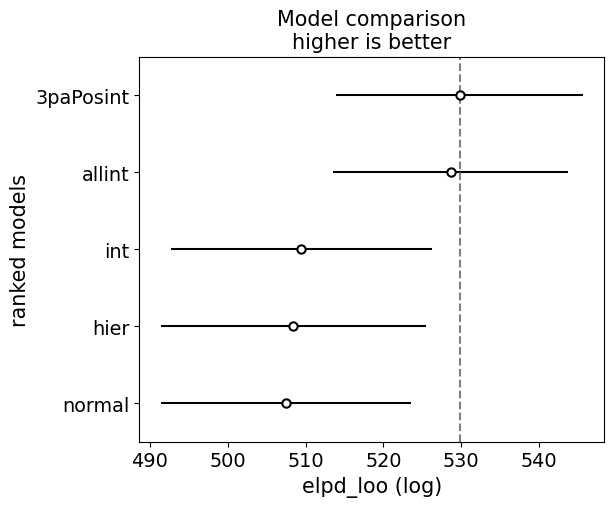

In [15]:
cmp_df_bmb = az.compare( {"normal":idata_pos_pred, "hier":idata_bb_h, "int":idata_bb_i, "allint":idata_bb_i2, "3paPosint":idata_bb_i3} )
az.plot_compare(cmp_df_bmb)

**Task11**:

Which model is "better" according to this metric?

Why do you think that is?

The models without any interactions are worse than the ones with an interaction. Bringing in the 3 point average stat makes the elpd_loo value increase by a significant amount. According to elpd_loo, there are two models that stand out as being "better" than all of the other ones: the one where interactions are placed in between every variable, and the one where an interaction is placed between 3PA and Pos. I think this is because 3PA, Pos, and FT percent are all linked, with your position determining how many 3 point shots you make and how good you might be at making a free throw.